In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import seaborn as sns
from datetime import datetime
import yfinance as yf
yf.pdr_override()

In [64]:
# Lista de tickers
tickers = ["PETR4.SA", 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA']
# Baixando os dados dos tickers
carteira = yf.download(tickers, start="2002-01-01", end='2023-12-31')['Adj Close']
# Baixando os dados do índice Ibovespa
ibov = yf.download('^BVSP', start="2002-01-01", end='2023-12-31')['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
def preencher_nans(df):
    # Preenche NaNs com o valor anterior (forward fill)
    df.ffill(inplace=True)
    # Para os casos onde o primeiro valor é NaN, preenche com o valor seguinte (backward fill)
    df.bfill(inplace=True)
    return df

In [66]:
caminho_do_arquivo = r'C:\Users\cptfr\Desktop\TCC_B3_OPCOES\estrategias\resultados_straddle.json'

# Lendo o arquivo JSON e transformando em DataFrame para manipulação de dados
retornos_straddle = pd.read_json(caminho_do_arquivo)
retornos_straddle

,Data_Entrada,Data_Vencimento,Tipo,Ativo,ResultadosTotais
0,20030702,20030818,STRADDLE,PETR4.SA,30.00
1,20031110,20031215,STRADDLE,PETR4.SA,30.00
2,20050114,20050221,STRADDLE,PETR4.SA,-30.00
3,20051111,20051219,STRADDLE,VALE3.SA,-23.65
4,20060329,20060515,STRADDLE,PETR4.SA,30.00
...,...,...,...,...,...
297,20231101,20231215,STRADDLE,BBAS3.SA,30.00
298,20230404,20230519,STRADDLE,BBDC3.SA,30.00
299,20230502,20230616,STRADDLE,BBDC3.SA,30.00
300,20230712,20230818,STRADDLE,BBDC3.SA,1.00


In [67]:
carteira_opcoes = pd.DataFrame(index = carteira.index,columns=['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA','saldo'])
colunas_modificar = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA']
carteira_opcoes.loc[carteira_opcoes.index[0], colunas_modificar] = 1666.66
carteira_opcoes['saldo']= carteira_opcoes.sum(axis=1)
carteira_opcoes.index = carteira_opcoes.index.strftime("%Y%m%d")
carteira_opcoes.index = carteira_opcoes.index.astype(int)
carteira_opcoes.reset_index(inplace=True)
carteira_opcoes

,Date,PETR4.SA,VALE3.SA,ITUB4.SA,BBAS3.SA,BBDC3.SA,saldo
0,20020101,1666.66,1666.66,1666.66,1666.66,1666.66,8333.3
1,20020102,NaN,NaN,NaN,NaN,NaN,0.0
2,20020103,NaN,NaN,NaN,NaN,NaN,0.0
3,20020104,NaN,NaN,NaN,NaN,NaN,0.0
4,20020107,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
5500,20231221,NaN,NaN,NaN,NaN,NaN,0.0
5501,20231222,NaN,NaN,NaN,NaN,NaN,0.0
5502,20231226,NaN,NaN,NaN,NaN,NaN,0.0
5503,20231227,NaN,NaN,NaN,NaN,NaN,0.0


In [68]:
for dia in carteira_opcoes['Date']:
    #print(dia)
    if dia in retornos_straddle['Data_Vencimento'].values:
        print(dia)
        posicao = carteira_opcoes.query('Date == @dia')
        posicao = int(posicao.index[0])
        ativo = retornos_straddle.loc[retornos_straddle['Data_Vencimento'] == dia, 'Ativo']
        # AQUI TA O BO
        print("ATIVOS NESTA DATA: \n {}".format(ativo))
        for ativos in ativo:
            print(ativos)
            #ativo = retornos_straddle.loc[retornos_straddle['Data_Vencimento'] == dia, 'Ativo'].iloc[0]
            resultado = retornos_straddle.loc[(retornos_straddle['Data_Vencimento'] == dia) & (retornos_straddle['Ativo'] == ativos), 'ResultadosTotais'].iloc[0]
            posicao_anterior = posicao - 1
            #print(ativos, resultado)
            for coluna in carteira_opcoes.columns:
                print(coluna)
                if coluna == ativos:
                    print("Resultado {}".format(resultado))
                    carteira_opcoes.loc[posicao, ativos] = carteira_opcoes.loc[posicao_anterior, ativos] * ((resultado/100)+1)
                elif coluna not in ativo.values:
                    if coluna != 'Date' and coluna != 'saldo':
                        print('Alterando {}'.format(coluna))
                        carteira_opcoes.loc[posicao, coluna] = carteira_opcoes.loc[posicao_anterior, coluna]
            carteira_opcoes.loc[posicao, 'saldo'] = carteira_opcoes.loc[posicao, ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA']].sum()
    elif dia!= carteira_opcoes['Date'].loc[0]:
        posicao = carteira_opcoes.query('Date == @dia')
        posicao = int(posicao.index[0])
        #print(posicao)
        #print(carteira_opcoes.loc[posicao])
        posicao_anterior = posicao - 1
        # Lista de colunas a serem modificadas
        colunas_mod = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA', 'saldo']
        # Usando .loc para acessar a linha e colunas_mod específicas e definir os valores de uma vez
        carteira_opcoes.loc[posicao, colunas_mod] = carteira_opcoes.loc[posicao_anterior, colunas_mod]

20030818
ATIVOS NESTA DATA: 
 0    PETR4.SA
Name: Ativo, dtype: object
PETR4.SA
Date
PETR4.SA
Resultado 30.0
VALE3.SA
Alterando VALE3.SA
ITUB4.SA
Alterando ITUB4.SA
BBAS3.SA
Alterando BBAS3.SA
BBDC3.SA
Alterando BBDC3.SA
saldo
20031215
ATIVOS NESTA DATA: 
 1    PETR4.SA
Name: Ativo, dtype: object
PETR4.SA
Date
PETR4.SA
Resultado 30.0
VALE3.SA
Alterando VALE3.SA
ITUB4.SA
Alterando ITUB4.SA
BBAS3.SA
Alterando BBAS3.SA
BBDC3.SA
Alterando BBDC3.SA
saldo
20050221
ATIVOS NESTA DATA: 
 2    PETR4.SA
Name: Ativo, dtype: object
PETR4.SA
Date
PETR4.SA
Resultado -30.0
VALE3.SA
Alterando VALE3.SA
ITUB4.SA
Alterando ITUB4.SA
BBAS3.SA
Alterando BBAS3.SA
BBDC3.SA
Alterando BBDC3.SA
saldo
20051219
ATIVOS NESTA DATA: 
 3    VALE3.SA
Name: Ativo, dtype: object
VALE3.SA
Date
PETR4.SA
Alterando PETR4.SA
VALE3.SA
Resultado -23.65
ITUB4.SA
Alterando ITUB4.SA
BBAS3.SA
Alterando BBAS3.SA
BBDC3.SA
Alterando BBDC3.SA
saldo
20060515
ATIVOS NESTA DATA: 
 4    PETR4.SA
Name: Ativo, dtype: object
PETR4.SA
Date
PETR

In [69]:
carteira = carteira.pct_change()
carteira_opcoes.set_index('Date', inplace=True)
carteira_opcoes = carteira_opcoes.pct_change()
carteira_opcoes = carteira_opcoes.drop('saldo',axis=1)
carteira_opcoes.rename(columns={'PETR4.SA': 'OP_PETR', 'VALE3.SA': 'OP_VALE','ITUB4.SA':'OP_ITUB','BBAS3.SA':'OP_BBAS','BBDC3.SA':'OP_BBDC'}, inplace=True)
carteira_opcoes.to_json(r'C:\Users\cptfr\Desktop\TCC_B3_OPCOES\carteiras+estrategias\retornos_straddle_op.json')
carteira_opcoes.index = pd.to_datetime(carteira_opcoes.index, format='%Y%m%d')
carteira_opcoes

,OP_PETR,OP_VALE,OP_ITUB,OP_BBAS,OP_BBDC
Date,,,,,
2002-01-01,NaN,NaN,NaN,NaN,NaN
2002-01-02,0.0,0.0,0.0,0.0,0.0
2002-01-03,0.0,0.0,0.0,0.0,0.0
2002-01-04,0.0,0.0,0.0,0.0,0.0
2002-01-07,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2023-12-21,0.0,0.0,0.0,0.0,0.0
2023-12-22,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0


In [70]:
df_combinado_outer = carteira_opcoes.join(carteira, how='outer')
df_combinado_outer

,OP_PETR,OP_VALE,OP_ITUB,OP_BBAS,OP_BBDC,BBAS3.SA,BBDC3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,,,,,,
2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,0.0,0.0,0.0,0.0,0.0,0.017941,0.000000,0.045514,0.001955,-0.019231
2002-01-03,0.0,0.0,0.0,0.0,0.0,0.015770,0.007614,-0.010924,0.006830,0.015686
2002-01-04,0.0,0.0,0.0,0.0,0.0,-0.022832,-0.003778,-0.016429,-0.006202,0.021235
2002-01-07,0.0,0.0,0.0,0.0,0.0,-0.022429,0.003792,-0.011117,0.021841,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.0,0.0,0.0,0.0,0.0,0.001476,-0.000646,0.006755,0.000275,0.033293
2023-12-22,0.0,0.0,0.0,0.0,0.0,0.002763,0.002486,0.015859,0.009618,-0.007535
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.009184,0.003987,0.010207,0.016059,0.003535


In [71]:
carteiras_normalizadas = {}  # Dicionário para armazenar as carteiras de cada ano
valor_inicial_ativos = 8333.33  # Valor inicial para normalização
valor_inicial_opcoes = 1666.66
acoes_lista = ['BBAS3.SA','BBDC3.SA','ITUB4.SA','PETR4.SA','VALE3.SA']
opcoes_lista = ['OP_PETR','OP_VALE','OP_ITUB','OP_BBAS','OP_BBDC']

for ano in range(2002, 2024):
    # Filtrar dados do ano atual e preencher NaNs
    carteira_ano = preencher_nans(df_combinado_outer[f'{ano}-01-01':f'{ano}-12-31'].copy())
    # Se for o primeiro ano, normalizar com base no primeiro valor
    carteira_normalizada = pd.DataFrame(index=carteira_ano.index,columns=['BBAS3.SA','BBDC3.SA',
                                                                          'ITUB4.SA','PETR4.SA','VALE3.SA','OP_PETR','OP_VALE','OP_ITUB','OP_BBAS','OP_BBDC','Saldo'])
    if ano == 2002:
        for coluna in carteira_ano.columns:
            if coluna in acoes_lista:
                carteira_normalizada[coluna].iloc[0] = valor_inicial_ativos
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]
            elif coluna in opcoes_lista:
                carteira_normalizada[coluna].iloc[0] = valor_inicial_opcoes
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]
        carteira_normalizada['Saldo'] = carteira_normalizada.loc[:,['BBAS3.SA','BBDC3.SA','ITUB4.SA','PETR4.SA','VALE3.SA','OP_PETR','OP_VALE','OP_ITUB','OP_BBAS','OP_BBDC']].sum(axis=1)
        saldo_final = carteira_normalizada.iloc[-1]['Saldo']
        print(carteira_normalizada)
    else:     
        for coluna in carteira_ano.columns:
            if coluna in acoes_lista:
                carteira_normalizada[coluna].iloc[0] = valores/6
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]
            elif coluna in opcoes_lista: 
                carteira_normalizada[coluna].iloc[0] = (((valores)/6)/5)
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]   
        # Para os anos seguintes, usar o valor proporcional do final do ano anterior
        #carteira_normalizada = (carteira_ano / carteira_ano.iloc[0]) * valores
    # Calcular o saldo e armazenar o valor final para o rebalanceamento no próximo ano
    carteira_normalizada['Saldo'] = carteira_normalizada.loc[:,['BBAS3.SA','BBDC3.SA','ITUB4.SA','PETR4.SA','VALE3.SA','OP_PETR','OP_VALE','OP_ITUB','OP_BBAS','OP_BBDC']].sum(axis=1)
    valores = carteira_normalizada['Saldo'][-1]
    # Armazenar a carteira normalizada no dicionário
    carteiras_normalizadas[ano] = carteira_normalizada
# Concatenando todas as carteiras normalizadas em um único DataFrame
carteira_total = pd.concat(carteiras_normalizadas.values())
# Exibindo o DataFrame resultante
print(carteira_total)

               BBAS3.SA     BBDC3.SA     ITUB4.SA     PETR4.SA      VALE3.SA  \
Date                                                                           
2002-01-01      8333.33      8333.33      8333.33      8333.33       8333.33   
2002-01-02  8482.840693      8333.33   8712.61019  8349.622273   8173.075396   
2002-01-03  8616.614508  8396.783693  8617.431828  8406.647756   8301.280336   
2002-01-04  8419.883772  8365.062168  8475.851912  8354.511345   8477.561343   
2002-01-07  8231.032764  8396.783693  8381.623528  8536.980881   8477.561343   
...                 ...          ...          ...          ...           ...   
2002-12-25  7743.145789  7127.748037  8049.696099  7943.953784  16043.263872   
2002-12-26  7711.672973  7043.150046  7957.359689  7803.843778  16346.150793   
2002-12-27  7632.987169  7614.215873  7990.508218   7600.19669  16346.150793   
2002-12-30  7711.672973  8090.106482  8120.720328  7559.463479  16490.377422   
2002-12-31  7711.672973  8090.106482  81

<AxesSubplot:xlabel='Date'>

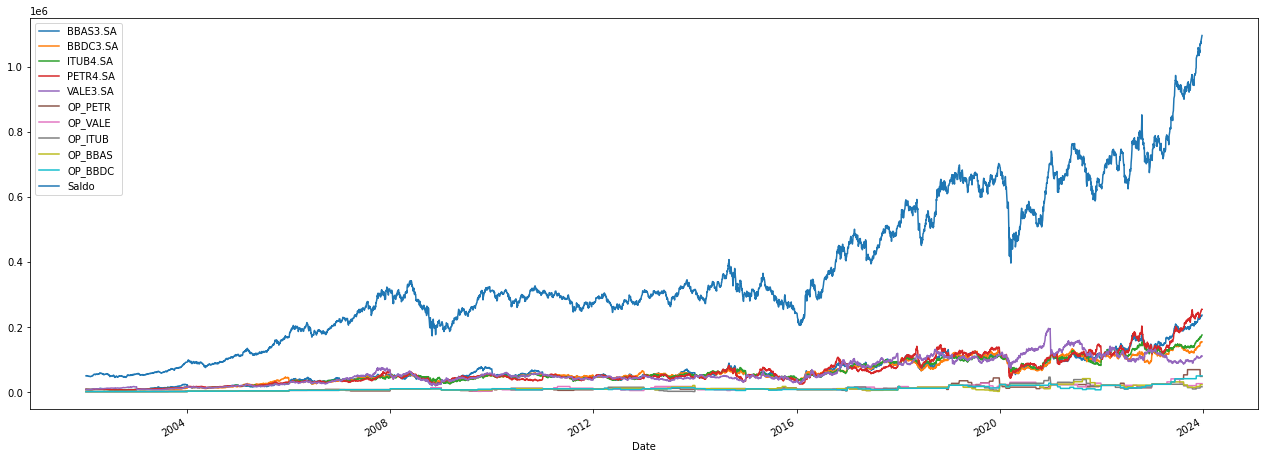

In [72]:
carteira_total.plot(figsize=(22,8))

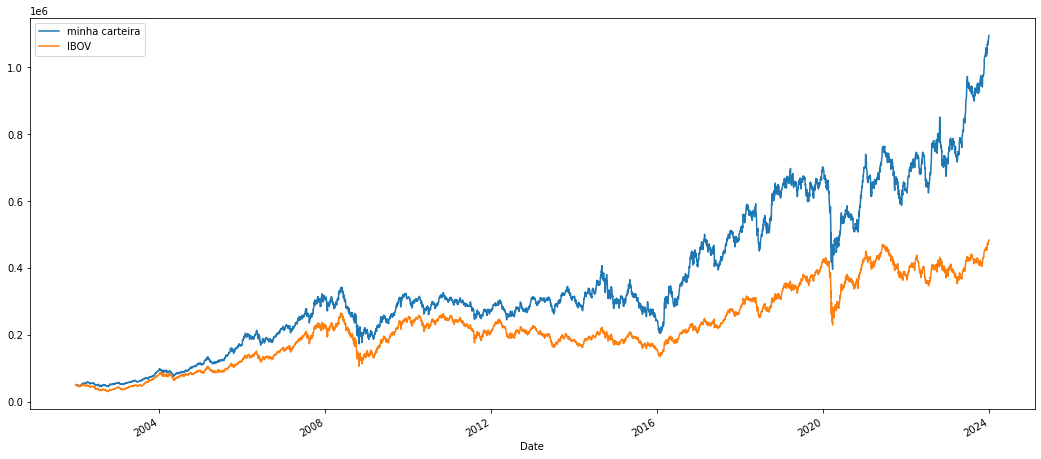

In [73]:
ibov_normalizado = (ibov / ibov.iloc[0])*50000
ibov_normalizado
carteira_total["Saldo"].plot(figsize=(18,8), label='minha carteira')
ibov_normalizado.plot(label="IBOV")
plt.legend()